# COGS 108 - Final Project 

*Fill in your overview here*

# Names

- Mariam Issa
- Andrea Sudharta
- Payam Sadeghian
- Brandon Amaral
- Alex Luo
- Jun Wang

# Group Members IDs

- A12285140
- A14497101
- A13654507
- A########
- A14430548
- A15743932

# Research Question

How consistent are Congressmen/Congresswomen with the beliefs they state on Twitter and how they vote on various issues in Congress?

## Background and Prior Work

The US government relies on its congress to check the powers of the president and other branches of government. One would expect to see nothing but honesty in this crucial cog of our government. It is shocking that members of Congress are some of the least trusted professionals. As Americans we assume those elected to serve us would want to preserve their reputation for honesty, but many people understand this isn't the case. Has lying become the norm for so long, that people have stopped caring. The Truther Tweet Team will uncover the reality of our government practices. In this project, we will analyze data to understand voting patterns and honesty in politicians and aim to uncover the deceivers in our congress. We will scan the Twitter accounts of congress members taking key words and hashtags for hot topics and compare their word against their voting patterns. Finally we will use statistical tests to decipher which members are significantly dishonest and those who aren’t.
	 Over the years the public’s primary source of information has switched from Newspaper to Television and now to the internet. Specifically, politicians have taken a liking to the social media platform, Twitter to spread proposals. The hashtag tool, the like, and retweet features have proven effective to spread information for members with the same ideological standing. Essentially the political left and the political right have split into two groups on social media. This may result in people not checking the information they see or what those they follow vote. They mostly attack each other and think less of the other group. This environment is perfect for lying politicians to gain support from the average member of the political party. We predict some members are greater liars than others. In this study we aim to uncover those who tend to lie, a lot.
	In other projects, those mainly research Trump’s impact on politics. The president is known as an excessive liar. Since Trumps’ introduction into politics, political analysts have seen a rise in lying accompanied by a defense of ‘fake news’ and ‘alternative facts’ against said lies. Other politicians have taken to such practices and we have one of the greatest problems in modern politics, excessive lying. “The Trump regime can be seen as post truth and hyper-Orwellian in its use of blatant lies, propaganda, and pure bullshit”. We can conclude that Trump has created an environment for lying politicians to grow.


References:
- 1)  https://www.forbes.com/sites/niallmccarthy/2019/01/11/americas-most-least-trusted-professions-infographic/#195b387c7e94
- 2) https://link.springer.com/chapter/10.1007/978-981-10-8013-5_7

# Hypothesis

H0: Both parties have the same consistency scores under 90% significant level. We predict that members of Congress will be mostly consistent between their tweets and their voting behavior, because of the easily accessible information that is available to the public (such as their voting ballots on GovTrack.us).  Coupling this watchdog effect, is the vast number of  media sources that serve to broadcast any unethical behavior from congress members, such as misleading and lying to their constituents on a platform such as Twitter.  The reason we are not predicting a 100% consistency in voting behaviors and Tweets is due to a lack of attentiveness of the American public in regards to how their representative votes, despite the easily-accessible information. Additionally, these past decades have witnessed a disappearance of investigative journalism, which means there may be a possibility of congress members voting with misaligned incentives due to low-risk repercussions.  This is an assumption that we would like to study in this project, because the extent of which this assumption is true will expose how honest congress members are to their constituents and to the general public.

# Dataset(s)

*Fill in your dataset information here*

(Copy this information for each dataset)
- Dataset Name:
- Link to the dataset:
- Number of observations:

1-2 sentences describing each dataset. 

If you plan to use multiple datasets, add 1-2 sentences about how you plan to combine these datasets.

# Setup

In [22]:
import pandas as pd
import numpy as np
import tweepy
from bs4 import BeautifulSoup
import datetime
from datetime import timedelta
import requests
import time
import seaborn as sns
import ast

In [ ]:
tweeters_dem_df = pd.read_csv('popular-tweeters-dem.csv') #Dataframe for list of Democratic Party politicians
tweeters_rep_df = pd.read_csv('popular-tweeters-rep.csv') #Dataframe for list of Republican Party politicians
tweeters_dem_df['Party'] = 'D'
tweeters_rep_df['Party'] = 'R'
tweeters_df = pd.concat([tweeters_dem_df, tweeters_rep_df], ignore_index = True) # Dataframe for combined list of politicians

tweeters_handle = list(tweeters_df['Twitter_Handle']) #Python list for politician Twitter handles

In [ ]:
# Get OAuth from Twitter
import tweepy

consumer_key = 'bSZRBubFkHWewMi08ltv7DgAu'
consumer_secret = '6JFpZu66GT7OvoJFFxSfJJlX21NH5wxmMjNDbsQGPLyW9WtBSU'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)

try:
    redirect_url = auth.get_authorization_url()
    print (redirect_url)
    
except tweepy.TweepError:
    print("Error! Failed to get request token.")

In [ ]:
# Verify Twitter account usage
verifier = raw_input('Verifier:')

In [ ]:
# Get Access Token
try: 
    auth.get_access_token(verifier)
except tweepy.TweepError:
    print ("Error! Failed to get access token.")

In [ ]:
# Save tokens
access_token = auth.access_token
acess_token_secret = auth.access_token_secret

# Note: You do not need to re-fetch it each time. Twitter currently does
# not expire the tokens, so the only time it would ever go invalid is if
# the user revokes our application access. 

#To rebuild an OAuthHandler from the stored access token

# auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(key, secret)

In [ ]:
# Check Set Up
api = tweepy.API(auth)
#api.update_status('tweepy + oauth!') # Posts directly on my timeline

In [37]:
# Filter tweets to only include those containing key words
key_words_by_bill = {
    0:['#savetheinternet', '#netneutrality', 'internet', 'neutrality'], 
    1:['#medicareforall', '#universalhealthcare','#healthcare', 'health', 'care', 'health', 'care', 'medicare'], 
    2: ['#equalpay', '#equalrights', '#equalrightsammendment', '#era', '#women', '#genderinequality', '#genderequality', 'equal', 'rights', 'pay', 'women', 'gender', 'equality'],
    3:['#votingrights', '#votingrightact', '#electionintegrity', '#riggedelections', '#forthepeople', 'voting', 'rights', 'elections', 'fair', 'vote', 'votes'], 
    4:['#guncontrol', '#2ndammendment', '#noguncontol', '#gunviolence', '#gunrights', '#gunreform', '#2a', 'gun', 'second', '2nd',  'amendment'], 
    5:['#yemen', '#yemengenocide', 'yemen', 'yemeni', 'war', 'troops', 'withdraw troops', 'civil'], 
    6:['#women', '#reauthorizationact', '#violenceagainstwomen', '#genderbasedviolence', '#sexualviolence', 'women'],  
    7:['#buildthewall', '#buildthewallnow', '#nationalsecurity', '#nationalemergency', '#trumpswall', '#illegalimmigration', '#mexico', '#border', '#bordercrises', 'mexico', 'illegal', 'immigration', 'security', 'emergency', 'build', 'wall']
}

key_words = list({x for v in key_words_by_bill.itervalues() for x in v})



In [ ]:
# Define Intersection Function
def interSection(arr1,arr2): 
    return list(filter(lambda x: x in arr1, arr2)) 

In [ ]:
# Collect all tweets that deal with each bill in Congress
bill = [{}] * 8 # bill[bill_number] = {congressman: [tweets about bill]}
tweets = {}

In [ ]:
bill_title = {
    0: "Save the Internet",
    1: "Health Care",
    2: "Paycheck Fairness Act",
    3: "For the People Act 2019",
    4: "Background Check for Firearms",
    5: "Remove Troops from Yemen",
    6: "Violence against Women Reauthorization Act",
    7: "Trump's National Emergency"
}

In [ ]:
#Iterate through Congressmen
for handle in tweeters_handle:
    all_tweets = []

    for i in range(1000):
        try:
            tweets_from_page_i = api.user_timeline(handle, count = 200, page = i) # max count value is 200
        except:
            print("TweepError: stopped at handle: ", handle, " at page ", i)
        
        # Check if we reached end of Twitter history
        if len(tweets_from_page_i) == 0: 
            break
            
        #iterate through each tweet, sort by bill
        for tweet in tweets_from_page_i:
            tweet_tokens = (tweet.text).lower().split()
            
            # See if Tweet talks about bill matter
            for bill_number, bill_tokens in key_words_by_bill.items():
                if len(interSection(tweet_tokens, bill_tokens)) != 0:
                    if bill[bill_number] == {}:
                        bill[bill_number] = {handle:[tweet.text]}
                    else:
                        if handle not in bill[bill_number]:
                            bill[bill_number][handle] = [tweet.text]
                        else:
                            bill[bill_number][handle] += [tweet.text]
                    
                    # Compile to all tweets list
                    all_tweets.append(tweet.text)
                    
    # Collect congressman/woman's tweets         
    tweets[handle] = all_tweets
        
    # Sleep: to not overload Twitter requests
    time.sleep(45)

In [ ]:
#Create look up table for Congressman/woman's name and party
tweeters_party = list(tweeters_df['Party'])
tweeters_name = list(tweeters_df['Name'])

handle_to_party = {}
handle_to_name = {}
for i, handle in enumerate(tweeters_handle):
    handle_to_party[handle] = tweeters_party[i]
    handle_to_name[handle] = tweeters_name[i]

data = [] 

# List all tweets by bill it's associated with and the congressman who tweeted it
for i in range(len(bill)):
    for handle, tweet in bill[i].items():
        data.append([handle_to_name[handle], handle_to_party[handle], handle, bill_title[i], tweet])
        
tweeters_df = pd.DataFrame(data, columns = ['Name', 'Party', 'Twitter Handle', 'Bill #', 'Tweet'])

# Export CSV with Tweets
tweeters_df.to_csv('tweets_by_bill')

# Data Cleaning

We created the Twitter dataset in the duration of this project, which meant that a number of the cleaning steps were carried out in the creation of the dataset. Since we chose to answer our data science question by selecting eight bills that were voted on in the 116th Congress, we filtered each representative’s Twitter history by only selecting Tweets that discerned one of the eight bills.  This was executed by checking whether or not the Tweet contained key words from the bill or a particular hashtag, demonstrating support for or against the bill. The last step taken in cleaning this data was the removal of any non-English words in the Tweet, which was due to the Tweepy library failing to remove all HTML code in the text part of the tweet. Python’s string function: isalpha() was used to remove these invalid parts of the Tweet text.  

As for the eight GovTrack CSV files, which contained the votes on all eight bills, the cleaning stage of this dataset involved dropping all rows of congress people who were not selected for analysis. After this first step was taken, the eight CSV files were then merged into a single CSV file, where each row contained a representative and a column corresponding to their party, state, and their votes on the eight bills.  In this step, concern was raised on whether these cleaning steps were properly done since many representatives did not vote on any of the bills. After careful inspection, it was deducted that many representatives were not voting on any of these bills, which is particularly interesting since the congress people were selected by how active and popular they are on Twitter.  

With these two datasets cleaned, the next step involved pre-processing the tweets into a numerical representation so that they can be directly compared to their voting pattern, which took on a value of ‘Yay, ‘Nay’, or ‘NA’ (no vote).  In order to categorize the tweets into the main two categories, we had to take a hybrid approach on how the text sentiment was conducted.  Detailed in the bill_sentiment() block of code (which was the function responsible for the text sentiment analysis), each bill contained key words or hashtags that inarguably reveals that politician’s sentiment  on the bill e.g. #trumpswall, which shows clear support for the bill of condemning Trump’s National Emergency to fund building the Mexican-American wall and the hashtag: #illegalimmigration, which supports Trump’s National Emergency, indicating a vote against the bill.  After this initial analysis, further sentiment analysis was carried out by utilizing Google’s Natural Language Processing Text Sentiment Analysis Cloud Tool to categorize the data. This step was particularly difficult to do since the NLP tool could only estimate the positivity and negativity of a tweet and since many congressmen’s tweets on Twitter are of a condescending tone, discerning their view on the topic was beyond the scope of analysis that could be done.  

This was a critical limitation on our project because deducing the sentiment in regards to whether or not they approve or disapprove of a bill is a Natural Language Processing Task that leading Deep Learning Researchers are conducting their research on.  Despite this, the Google NLP tool was still used to get the sentiment score, a number between -1 (negative) and 1 (positive) and depending on the bill, this number was multiplied by -1 to capture whether the congress person would vote for or against a bill (this was done to standardize the sentiment and align the sentiment score with the predicted vote on a bill). After this step, the list of tweet texts, pertaining to each bill, became a list of sentiment scores, which was then averaged into a single number.  Finally, this score was converted into a 1 if it fell in the range [0.1, 1.0] to indicate support for the bill, a 0 if the score fell in the range [-0.1, 0.1] for a NA (no vote), or -1 if it fell between [-1.0, -0.1], as a vote against the bill.  After these cleaning steps, the dataset was set up to do a simple comparison between their predicted Tweet sentiment score and their recorded vote.

In [35]:
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/mariamissa/Downloads/politician-tweet-sentiment-4910a807f774.json"

# Instantiates a client
client = language.LanguageServiceClient()

In [36]:
# pass in a string
def sentimentAnalysis(text):
    document = types.Document(content=text, type=enums.Document.Type.PLAIN_TEXT)
    
    # Detects the sentiment of the text
    sentiment = client.analyze_sentiment(document=document).document_sentiment
    
    return sentiment.score, sentiment.magnitude
    

In [18]:
from nltk.tokenize import word_tokenize

tweets_df = pd.read_csv('tweets_by_bill')

all_sentiment_scores = []
avg_scores = []
mdn_scores = []
rng_scores = [] 
var_scores = [] 
std_dev_scores = []

for bill, tweets in zip(tweets_df['Bill #'], tweets_df['Tweet']):
    
    tweet_scores = []
    
    for twt in tweets.split('u\''): 
        # Clean tweet
        twt = ' '.join([word.lower() for word in twt.split(' ') if word.isalpha()])
        
        # Skip empty strings
        if twt == '': continue 
            
        # To not overload Google API
        time.sleep(1)
            
        # Evaluate by bill
        tweet_scores.append(bill_sentiment(twt, bill))
    
        
    # Add list of scores to Dataframe
    all_sentiment_scores.append(tweet_scores)
    
    # Get AVERAGE tweet sentiment score
    avg = sum(tweet_scores) * 1.0 / len(tweet_scores)
    avg_scores.append(avg)
        
    # Get MEDIAN tweet sentiment score
    sorted_tweet_scores = sorted(tweet_scores)
    mdn = sorted_tweet_scores[len(tweet_scores) / 2]
    mdn_scores.append(mdn)
        
    # Get RANGE tweet sentiment score
    rng = sorted_tweet_scores[len(tweet_scores) - 1] - sorted_tweet_scores[0]
    rng_scores.append(rng)
        
    # Get VARIANCE tweet sentiment score
    if len (tweet_scores) <= 1:
        var = sum([(score - avg)**2 for score in tweet_scores]) 
    else:
        var = sum([(score - avg)**2 for score in tweet_scores]) * 1.0 / (len(tweet_scores) - 1)
    var_scores.append(var)
    
    # Get STD DEVIATION tweet sentiment score
    std_dev = var**(1/2)
    std_dev_scores.append(std_dev)
         
# Add to dataframe
tweets_df['Sentiment Scores'] = all_sentiment_scores
tweets_df['Average'] = avg_scores
tweets_df['Median'] = mdn_scores
tweets_df['Range'] = rng_scores
tweets_df['Variance'] = var_scores
tweets_df['Standard Deviation'] = std_dev_scores

# Export new file
tweets_df.to_csv('tweet_sentiment_analysis')

In [8]:
#Note: 1 >= score > 0    Vote YES on bill
#      0 >= score >= -1  Vote NO on bill
def bill_sentiment(tweet, bill):
    if bill == "Save the Internet":
        if ('#savetheinternet' in tweet) or ('#netneutrality' in tweet) or ('neutrality' in tweet):
            return 1.0
        
        score, mag = sentimentAnalysis(tweet)
        
        return -1 * score
               
    elif bill == "Health Care":
        if ('#medicareforall' in tweet) or ('#universalhealthcare' in tweet):
            return 1.0
        
        score, mag = sentimentAnalysis(tweet)
        
        return -1 * score
        
    elif bill == "Paycheck Fairness Act":
        if 'genderinequality' in tweet:
            return 1.0
        
        score, mag = sentimentAnalysis(tweet)
        
        return -1 * score
        
    elif bill == "For the People Act 2019":
        if ('#votingrights' in tweet) or ('#riggedelections' in tweet) or ('#forthepeople' in tweet):
            return 1.0
   
        score, mag = sentimentAnalysis(tweet)
        
        return -1 * score
        
    elif bill == "Background Check for Firearms":
        if ('#guncontrol' in tweet) or ('#gunviolence' in tweet) or ('gunreform' in tweet):
            return 1.0
        if ('#gunrights' in tweet) or  ('noguncontrol' in tweet):
            return -1.0
        
        score, mag = sentimentAnalysis(tweet)
        
        return score
        
    
    elif bill == "Remove Troops from Yemen":
        if '#yemengenocide' in tweet:
            return 1.0
        
        score, mag = sentimentAnalysis(tweet)
        
        return -1 * score
    
    elif bill == "Violence against Women Reauthorization Act":
        if ('#violenceagainstwomen' in tweet) or ('#genderbasedviolence' in tweet) or ('#sexualviolence' in tweet):
            return 1.0
        
        score, mag = sentimentAnalysis(tweet)
        
        return -1 * score
    
    elif bill == "Trump's National Emergency":
        if  '#trumpswall' in tweet:
            return 1.0
        
        if ('#buildthewall' in tweet) or ('#buildthewallnow' in tweet) or ('#bordercrises' in tweet) or ('#illegalimmigration' in tweet) or ('illegal' in tweet):
            return -1.0
        
        score, mag = sentimentAnalysis(tweet)
        
        return -1 * score
              
    else:
        return 0

Describe your data cleaning steps here.

# Data Analysis & Results

Include cells that describe the steps in your data analysis.

In [5]:
sentim = pd.read_csv('Tweet_Truth/tweet_sentiment_analysis.csv')
sentim = sentim.iloc[:, 2:]
sentim.columns = ['Name', 'Party', 'Twitter', 'Bill', 'Tweet', 'Sent', 'Average', 'Median', 'Range', 'Variance', 'SD']
sentim['Name'] = sentim['Name'].apply(lambda x: x.lower().strip())
sentim = sentim.drop(['SD', 'Variance', 'Range'], 1)

In [7]:
govtrack = pd.read_csv('Tweet_Truth/govtrack.csv')
govtrack['vote'] = govtrack['vote'].apply(lambda x: 0 if x == -1 else -1 if x == 0 else x)
govtrack.columns = ['State', 'Vote', 'Name', 'Party', 'Bill']

In [18]:
votes = sentim.copy().merge(govtrack.copy(), how = 'left', on = ['Name', 'Party', 'Bill'])
senators = ['chuck grassley', 'clay higgens', 'john barrasso', 'john cornyn',
            'john thune', 'joni ernst', 'marco rubio', 'mike enzi', 'mitch mcconnell',
            'mitt romney', 'rob porman']
votes_mod = votes[~votes['Name'].isin(senators)]
votes_mod['Vote'] = votes_mod['Vote'].fillna(0)
votes_mod['Sent'] = votes_mod['Sent'].apply(ast.literal_eval)
votes_mod.index = range(len(votes_mod))
votes_mod['Tweet'] = votes_mod['Tweet'].apply(ast.literal_eval)

/Users/alexluo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/alexluo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/alexluo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.

In [21]:
# this weigh function finds a label based on the sum of the sentiments and the sign.
def weigh(x):
    return np.sign(sum(x))

In [23]:
votes_mod['Label'] = votes_mod['Sent'].apply(weigh)
votes_mod['Consistent'] = votes_mod['Label'] == votes_mod['Vote']

/Users/alexluo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/alexluo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [28]:
votes_mod.to_csv('consistencies.csv', index = False)

In [24]:
overall_cons = votes_mod['Consistent'].mean()
overall_cons

0.4171632896305125

In [41]:
by_name = votes_mod.groupby(['Name'])['Consistent'].mean()
by_name

Name
adam kinzinger              0.750000
adam schiff                 0.500000
adrian smith                0.750000
alan lowenthal              0.375000
alexandria ocasio-cortez    0.500000
annie kuster                0.000000
austin scott                0.875000
barbra lee                  0.000000
barry loudermilk            0.875000
bill foster                 0.125000
bill huizenga               0.750000
bill johnson                0.875000
bob gibbs                   0.875000
bob latta                   0.000000
brenda lawrence             0.375000
brian babin                 0.875000
cathy rodgers               0.000000
cheri bustos                0.125000
chip roy                    0.714286
dan kildee                  0.000000
dan newhouse                0.750000
daniel webster              0.875000
david b mckinley            0.000000
deb dingell                 0.000000
debbie wasserman schultz    0.625000
derek kilmer                0.125000
devin nunes                 0.750

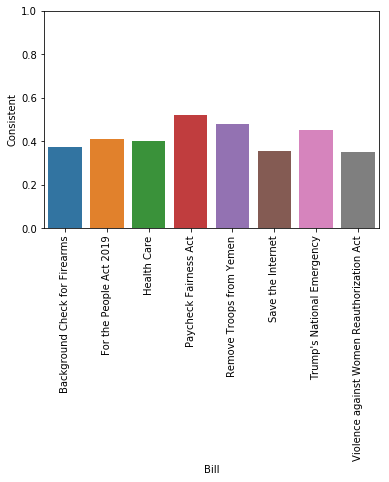

In [51]:
by_bill = votes_mod.groupby(['Bill'])['Consistent'].mean()
by_bill_plot = sns.barplot(x = by_bill.index, y = by_bill)
by_bill_plot.set_xticklabels(labels = by_bill.index, rotation=90);
by_bill_plot.axes.set_ylim(0,1);

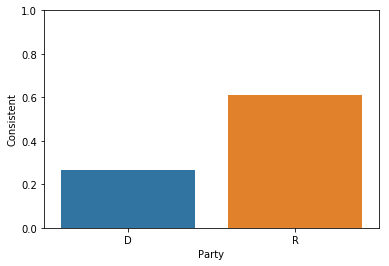

In [52]:
by_party = votes_mod.groupby(['Party'])['Consistent'].mean()
by_party_plot = sns.barplot(x = by_party.index, y = by_party)
by_party_plot.axes.set_ylim(0,1);

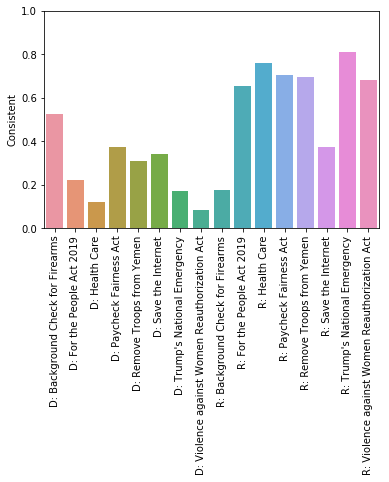

In [54]:
by_party_bill = votes_mod.groupby(['Party', 'Bill'])['Consistent'].mean()
party_bill_ind = [x + ": " + y for x,y in by_party_bill.index]
by_party_bill = sns.barplot(x = party_bill_ind, y = by_party_bill)
by_party_bill.set_xticklabels(labels = party_bill_ind, rotation=90);
by_party_bill.axes.set_ylim(0,1);

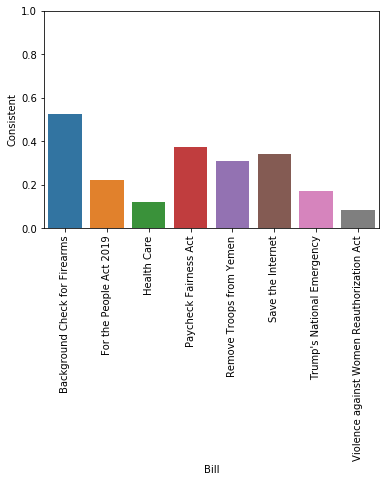

In [56]:
dems = votes_mod[votes_mod['Party'] == 'D'].copy()
dems['Consistent'] = dems['Label'] == dems['Vote']
dems_by_bill = dems.groupby('Bill')['Consistent'].mean()
dems_by_bill_plot = sns.barplot(x = dems_by_bill.index, y = dems_by_bill)
dems_by_bill_plot.set_xticklabels(labels = dems_by_bill.index, rotation=90);
dems_by_bill_plot.axes.set_ylim(0,1);

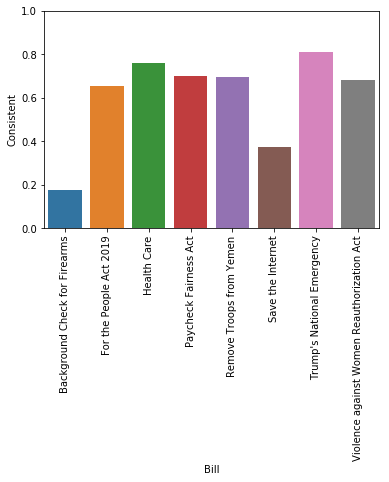

In [58]:
reps = votes_mod[votes_mod['Party'] == 'R'].copy()
reps_by_bill = reps.groupby('Bill')['Consistent'].mean()
reps_by_bill_plot = sns.barplot(x = reps_by_bill.index, y = reps_by_bill)
reps_by_bill_plot.set_xticklabels(labels = reps_by_bill.index, rotation=90);
reps_by_bill_plot.axes.set_ylim(0,1);

# Ethics & Privacy

In order to web scrape Twitter for the tweet history of each congressman/woman, a Twitter Developer Account had to be requested from the company. Once this step was completed, we had the permission to collect all the Twitter data we needed to formulate the dataset. As for the GovTrack datasets, the CSV files, containing the votes on a bill from each House of Representatives, are public records (since the transparency of representatives voting record is vital for maintaining a representative democracy) no permission was needed.  

In terms of privacy, this was not an issue for the GovTrack files since the CSV files are online and downloadable with no usage restrictions.  As for using the Twitter API and the tweepy library, there was a restriction on the number of page requests that could be made in an hourly basis. Thus, curating the dataset required the sleep function to be used to stay within Twitter’s allowance of web scraping.

Working on this type of problem involved various challenges in terms of answering our data science question without bias. To best represent the population we are studying, the following steps were completed: an even number of representatives were selected from both the Democratic and Republican party; a systematic way of selecting which of the 435 politicians from the House of Representatives to use for analysis was specified (those with the most tweets and followers).  As for selecting which of the bills voted on in the House were used for analysis: the bills that had the most divide were used i.e. there was a near even split of votes.  This method of selecting bills was advantageous since it avoided biasedly selecting bills introduced to the house disproportionately by one party.  However, there was a significant issue in terms of how to filter the Tweet data.  The list of key words belonging to each bill were accumulated by taking key words in each of the bill statements and from analyzing the most popular results from searching each of the bills on Twitter. Whether or not Twitter has algorithm bias in their search results was out of the project’s scope of control; however, selecting the hashtags from these search results left room for human bias to unintendedly select a biased list of words and hashtags.  This was a challenge to the project since the poor execution of the step would skew the data set by disproportionately containing tweets predominantly from one side of the vote. However, since this was an issue raised before curating this list of key words, emphasis was places on analyzing tweets from both parties. 

# Conclusion & Discussion

*Fill in your discussion information here*